# Classification

# MNIST

本章始用 MNIST 數據集，這是由高中學生和美國人口普查局的僱員手寫的一組 70,000 個數字圖像。每個圖像都用其代表的數字標記。 這個數據集通常被稱為機器學習的 'Hello World'。

Scikit-Learn 有提供一些流行的數據集下載。MNIST 也是其一。

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from sklearn.datasets import fetch_mldata

In [3]:
#mnist = fetch_mldata('MNIST original')  書中所使用，但會無法下載資料集
mnist = fetch_mldata('MNIST original', transpose_data = True, data_home = 'datasets')
mnist

# 使用書中的 mnist = fetch_mldata('MNIST original') 會無法下載資料集，應該是原始的網站有問題，因此先另外下載 mnist-original.mat 檔案於本機上直接讀取使用

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

使用 Scikit-Learn 下載的數據集通常有一類似於字典的結構：
 * 'DESCR' 用來描述數據集
 * 'data' 包含一個數組，每個實例為一列，每個特徵為一行
 * 'target'，包含一個帶有標記的數組

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

X 數據集，是一個 70000 x 784 的數組：70000 列，784 行。 共有 70000 張圖片，每張圖片有 784 個特徵，這是因為圖片是 28 x 28 像素，每個特徵代表了一個像素點的强度，從 0（白色）到 255（黑色）。 

將一個實例的特徵向量，重新形成一個 28 * 28 的數組，再使用 Matplotlib 的 imshow() 顯示出來。

In [7]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

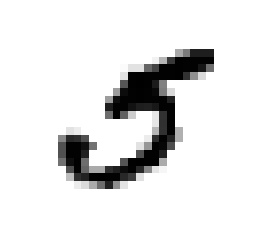

In [8]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
plt.axis('off')

plt.show()

標籤顯示

In [9]:
y[36000]

5.0

（作者 github 內的內容）

將上述的內容定義為一個函數使用

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation = 'nearest')
    plt.axis('off')

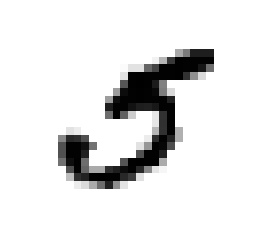

In [11]:
plot_digit(X[36000])

In [12]:
#Figure 3-1 程式碼
# EXTRA 
def plot_digits(instances, images_per_row = 10, **options):
    size = 28
    
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size, size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    
    row_images = []
    
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis = 1))
        
    image = np.concatenate(row_images, axis = 0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis('off')

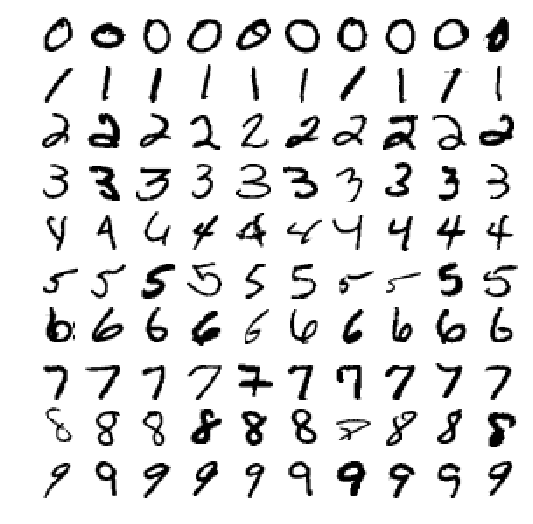

In [13]:
plt.figure(figsize = (9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row = 10)
#save_fig('more_digits_plot')

plt.show()

In [14]:
X[:12000:600].shape

(20, 784)

In [15]:
X[13000:30600:600].shape

(30, 784)

In [16]:
X[30600:60000:590].shape

(50, 784)

MNIST 數據集已經分成訓練集（前 6 萬張圖像）和測試集（最後 1 萬張圖像）

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [18]:
X_train.shape

(60000, 784)

In [19]:
X_test.shape

(10000, 784)

將訓練數據洗牌，才能保證交叉驗證時所有的折疊都差不多。

In [20]:
# Shuffle the training set; this will guarantee that all cross-validation folds will be similar 
import numpy as np

In [21]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Training a Binary Classifier

只嘗試來識別一個數字，是 5 或者不是 5。這是一個二元分類器的例子。

先建立目標向量

In [22]:
y_train_5 = (y_train == 5)       # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [23]:
y_train_5

array([False, False,  True, ..., False, False, False])

選擇一個的分類器開始訓練，先選擇的是**隨機梯度下降（SGD）**，即 Stochastic Gradient Descent。使用 Scikit-Learn 中 SGDClassifier 即可。SGD 優勢是能夠有效的處理大型數據，這是因為之 SGD 在每一時刻只處理一個訓練實例，這也導致它適合於**在線學習（online learning）**。

In [24]:
from sklearn.linear_model import SGDClassifier

In [25]:
#sgd_clf = SGDClassifier(max_iter = 5, random_state = 42)
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

用此來檢測數字 5 的圖像

In [26]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

評估分類器比評估回歸器要困難許多。

## Measuring Accuracy Using Cross-Validation

使用交叉驗證評估模型是一個不錯的辦法

用 cross_val_score() 來評估 SGDClassifier 模型，採用 K-fold 交叉驗證法，這邊設定 3 個折疊。

K-fold 交叉驗證法式將訓練集分解成 K 個折疊，然後每次留其中 1 個折疊進行預測，剩餘的折疊用來訓練。

In [27]:
from sklearn.model_selection import cross_val_score

In [28]:
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDCla

array([0.95885, 0.94625, 0.96495])

結果有超過 95% 的準確率，看起來不錯的樣子～

創建一個將每張圖都分類成“非 5”的分類器

In [29]:
from sklearn.base import BaseEstimator

In [30]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [31]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.9107 , 0.90885, 0.9094 ])

結果也超過 90% 的準確率。之所以出線這樣的情況是因為在 MNIST 中，數字 5 占了 10% 左右，所以猜一張圖不是數字 5 ，90% 都會是對的。

這說明了對於 classifiers 為什麼準確率通常不是首選的性能指標，尤其是在處理**偏斜數據集**時（即，當某些類比其他類更為頻繁）。

Implementing Cross-Validation 實施交叉驗證

可自行實施交叉驗證，以下代碼與先前 cross_val_score() 大致相同，並印出相同結果

每個折疊由 StratifiedKFold 執行分層抽樣產生，所包含的各個類的比例符合整體比例。每個迭代會創建一個分類器的副本，用訓練集對這個副本進行訓練，然後用測試集進行預測。最後計算正確預測的次數，輸出正確預測的比率。

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [ ]:
'''
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print(n_correct / len(y_pred))

## Confusion Matrix

評估分類器效能最好的方法是使用混淆矩陣（Confusion Matrix）。

一般的想法是計算 A 類實例被分類為 B 類的次數。首先需要有一組預測，以便他們可以與實際目標進行比較。

In [32]:
from sklearn.model_selection import cross_val_predict

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDCla

與 cross_val_score() 一樣， cross_val_predict() 同樣執行 K-fold 交叉驗證，但返回的不是評估分數，而是每個折疊的預測。

使用 confusion_matrix() 來取得混淆矩陣。只需給出目標類別（y_train_5）和預測類別（y_train_pred）。

In [34]:
from sklearn.metrics import confusion_matrix

In [35]:
confusion_matrix(y_train_5, y_train_pred)

array([[53167,  1412],
       [ 1187,  4234]])

混淆矩陣中的列表是實際類別，行表示預測類別。

negative class  [[ **true negatives** , **false positives** ]
 
positive class  [ **false negatives** , **true positives** ]]

第一列表示**非5**的圖片，**negative class** ：

* true negatives:  53,167 張被正確的分類為非 5
* false positives：1,412 張被錯誤的分類為 5

第二列表示**是5**的圖片，**positive class** ：

* false negatives：1,187 張被錯誤的分類為非 5
* true positives： 4,234 張被正確的分類為 5

一個完美的分類器應該只有**真正類（true positives）** 和 **真負類（true negatives）**，所以其混淆矩陣只會在主對角線有不為 0 的值，其於為 0。

全部加起來的數字會等於所有的測試集數。

In [36]:
y_train_perfect_predictions = y_train_5

In [37]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

正類預測的準確率可視為一個指標，也稱為分類器的*精度*。

**精度 Precision**

**$ precision = \frac {TP} {TP + FP} $**

* TP is the number of true positives 真正類的數量
* FP is the number of false positives 假正類的數量

精度通常與另一個指標一起使用，這個指標就是*召回率（recall）*，也稱為*靈敏度（sensitivity）*或是*真正類率（TPR）*，它是分類器正確檢測到的正類實例的比率。

**召回率 Recall**

**$ recall = \frac {TP} {TP + FN} $**

* TP is the number of true positives 真正類的數量
* FP is the number of false positives 假正類的數量
* FN is of course the number of false negatives. 假負類的數量

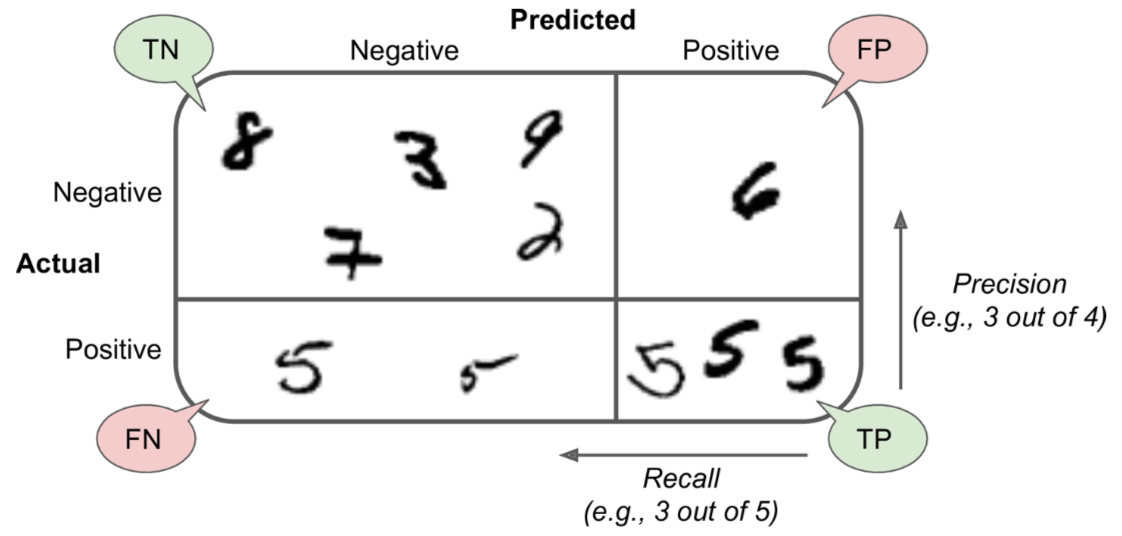

## Precision and Recall

In [38]:
from sklearn.metrics import precision_score, recall_score

In [39]:
precision_score(y_train_5, y_train_pred)    # 4234 / (4234 + 1412)

0.7499114417286574

In [40]:
recall_score(y_train_5, y_train_pred)   # 4234 / (4234 + 1187)

0.781036709094263

這樣的結果表示，說一張圖片是 5 時，只有 70% 的時間是準確的，且也只有 77% 的數字 5 被它檢測出來。

將**Precision** 和 **Recall** 組合成一個單一的指標，稱為 **F1 score** 。**F1 score** 是精度和召回率的調和平均值（諧波平均值）。正常的平均值平等地處理所有值，但調和平均值（諧波平均值）給予較低的值更高的權重。 因此，如果召回率和精度都很高時，分類器才能獲得較高 F1 score。

$ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$



In [41]:
from sklearn.metrics import f1_score

In [42]:
f1_score(y_train_5, y_train_pred)

0.7651576759736154

F1 score對於那些具有相近的精度和召回率的分類器更為有利。在某些情況下，會特別注重精度，而某些情況下則是注重召回率，但不能同時增加精度並減少召回率，反之亦然，這稱為精度/召回率權衡（Precision/Recall Tradeoff）。

## Precision/Recall Tradeoff

**SGDClassifier** 的分類決定是對每個實例，會基於決策函數計算得分，如果得分大於閾值，則將實例分配給**正類（positive class）**，否則便將其判為**負類（negative class）**。

下圖顯示從左側最低分到右側最高分。假設決策閾值位於中心箭頭（兩個 5s 之間）：在閾值的右側可以找到 4 個**真正類（true positives）**（真的 5），和一個**假正類（false positive）**（實際為 6）。因此，在該閾值下，**精度**為 80％（4/5）。但是在 6 個真正的 5 中，分類器僅檢測到 4 個，所以**召回率**為 67％（4/6）。

如果提高閾值（將其移動到右邊的箭頭），**假正類（false positive）**（數字 6）變為**真負類（true negative）**，因此提高了**精度**（在這情況下達到 100％），但一個**真正類（true positive）** 變為**假負類（false negative）**，**召回率**降低至 50％。相反，降低閾值則會**增加召回率**同時也**降低精度**。

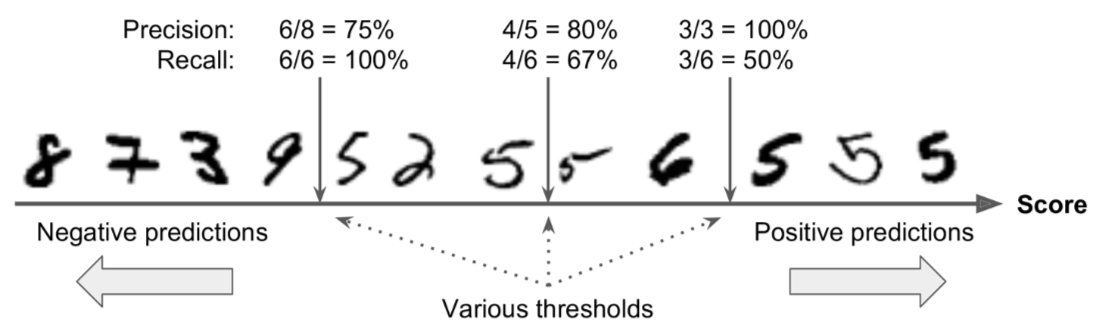

Scikit-Learn 不允許直接設置閾值，但可以訪問它用於進行預測的決策分數。不是使用分類器的 predict()，而是使用其 decision_function()，該方法返回每個實例的分數，然後就可以根據這些分數，使用任意閾值進行預測

In [43]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([140385.79530935])

In [44]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

這邊設定 SGDClassifier 分類器使用的閾值為 0，所以和前面返回的結果與 predict() 一樣，也就是 True。

嘗試來提昇閾值

In [45]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

這證明提高了閾值確實可以降低召回率。

要如何決定使用什麼閾值？使用 cross_val_predict() 取得訓練集中所有實例的分數，因此這次要返回的是決策分數而不是預測結果。

In [46]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function')

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDCla

In [47]:
y_scores.shape

(60000,)

现在有了這些分數，可以使用 precision_recall_curve() 計算所有可能的精度和召回率的閾值

In [48]:
from sklearn.metrics import precision_recall_curve

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

最後，使用 Matplotlib 繪製精度和召回率相對於閾值的函數圖

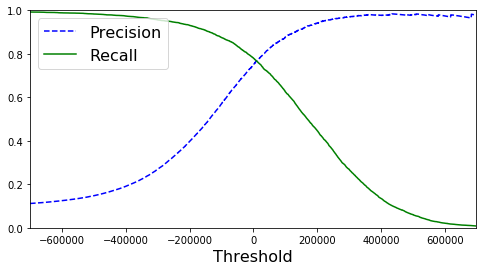

In [51]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label = 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold', fontsize = 16)
    plt.legend(loc = 'upper left', fontsize = 16)
    plt.ylim([0,1])
    
plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

plt.show()

In [52]:
(y_train_pred == (y_scores > 0)).all()

True

另一種找到好的精度/召回率權衡的方法是繪製精度和召回率的函數圖

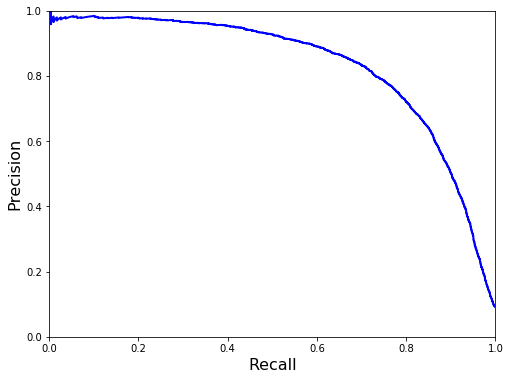

In [53]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls,  precisions, 'b-', linewidth = 2)
    plt.xlabel('Recall', fontsize = 16)
    plt.ylabel('Precision', fontsize = 16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize = (8, 6))
plot_precision_vs_recall(precisions, recalls)

plt.show()

可以看到，在召回率為 80% 時，精度開始急遽下降。會希望在該下降之前選擇精度/召回權衡 - 例如，召回率約為 60％。 但這還是得取決於项目的要求。

假設決定瞄准 90％ 的精度目標。 透過繪製的第一張圖，得出需要使用的閾值大約是 70,000。 要做預測（現在是在訓練集上），如果不使用分類器的predict() ，也可以執行以下這段代碼。

In [54]:
y_train_pred_90 = (y_scores > 70000)

In [55]:
precision_score(y_train_5, y_train_pred_90)

0.8468075333027102

In [56]:
recall_score(y_train_5,y_train_pred_90)

0.6801328168234643

結果顯示這是一個 85% 精度的分類器。只要閾值夠高，要創建一個想要的精度分類器是件容易的事。

如果召回率太低，精度再高，也是不怎麼有用。

如果有人說：“我們需要 99% 的精度。“ 你就應該問：”召回率是多少？”

## The ROC Curve

還有一種經常與二元分類器一起使用的工具，叫做 **receiver operating characteristic 曲線（ROC curve）**。繪製的是**真正類率（召回率）**和**假正類率（FPR）**。FPR 是被錯誤分為正類的負類實例比率。它等於 1 減去真負類率（TNR），真負類率是被正確分類為負類的負類實例比率，也稱為**特異度**。

ROC 曲線繪製的是靈敏度和（1 - 特異度）的關係。

要繪製 ROC 曲線，需要使用 roc_curve() 計算多種閾值的 TPR 和 FPR

In [57]:
from sklearn.metrics import roc_curve

In [59]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [62]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

<function matplotlib.pyplot.show(*args, **kw)>

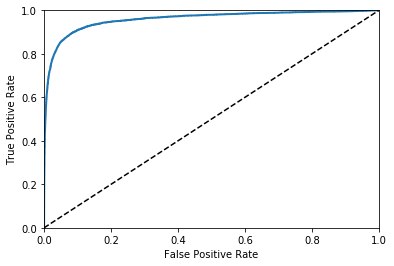

In [63]:
plot_roc_curve(fpr, tpr)

plt.show

召回率（TPR）越高，分類器產生的假分類（FPR）就越多。虛線表示純隨機分類器的 ROC 曲線，一個優秀的分類器應該離這條線越遠越好，越往左上角越好。

比較分類器的一種方法是測量曲線下面積（AUC）。完美分類器的 ROC AUC 等於 1，而純隨機分類器的 ROC AUC 等於 0.5。

Scikit-Learn 有提供計算 ROC AUC 的方法

In [64]:
from sklearn.metrics import roc_auc_score

In [65]:
roc_auc_score(y_train_5, y_scores)

0.9592547551834605

ROC 曲線和精度/召回率（PR）曲線很相似，要如何決定該使用哪種曲線，可以參考的是，**當正類非常少見或著需要更關注假正類而不是假負類時，應該要選擇 PR 曲線，反之則是 ROC 曲線**。

可以看先前的例子，前圖 ROC 曲線（及 ROC AUC 分數），會覺得分類器表現不錯，但這是因為跟負類（非 5）相比，正類（數字 5）的數量真的很少，因此再看先前的 PR 曲線圖，可以看出分類器還有改善的空間，曲線還可以更接近右上角。

訓練一個 RandomForestClassifier 分類器比較和 SGDClassifier 分類器的 ROC 曲線和 ROC AUC 分數。

首先需要獲得訓練集中每個實例的分數。

但 RandomForestClassifier 沒有 decision_function()，而是有一個 predict_proba()。Scikit-Learn 分類器通常都會有這兩種方法的一種。

predict_proba() 返回一個數組，這個數組的每一列包含一个实例，每一行代表一個類，意思是某個給定實例屬於每個給定類別的機率（例如，這張圖片有 70% 的可能是數字 5）

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
forest_clf = RandomForestClassifier(random_state = 42)

In [68]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


要繪製 ROC 曲線，需要的是得分，而不是機率。 簡單的解決方案是使用正類的機率作為分數

In [69]:
y_scores_forest = y_probas_forest[:, 1]        # score = proba of positive class

In [70]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

繪製 ROC 曲線

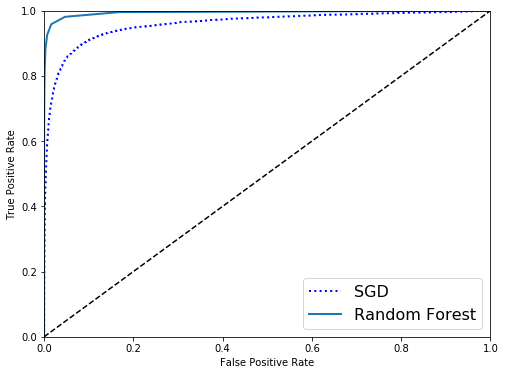

In [73]:
# It is useful to plot the first ROC curve as well to see how they compare
plt.figure(figsize = (8, 6))

plt.plot(fpr, tpr, 'b:', linewidth = 2, label = 'SGD')

plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')

plt.legend(loc = 'lower right', fontsize = 16)

plt.show()

In [74]:
roc_auc_score(y_train_5, y_scores_forest)

0.9941894971817936

從圖中可以看到 RandomForestClassifier 的 ROC 曲線要比 SGDClassifier 好很多：它離左上角更接近。ROC AUC score 也高得多。

計算 Precision and Recall scores

In [75]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [76]:
precision_score(y_train_5, y_train_pred_forest)

0.983824506979836

In [77]:
recall_score(y_train_5, y_train_pred_forest)

0.8190370780298838

現已經掌握如何訓練二元分類器：
- 如何選擇合適的指標利用交叉驗證來對分類器進行評估
- 如何選擇滿足需求的精度/召回率權衡
- 如何使用 ROC 曲線和 ROC AUC 分數來比較多個模型

以上是屬於二分類，結果只有兩個：是或者不是。

# Multiclass Classification

多分類分類器（也稱為多項分類器）可以區分兩個以上的類別。

有些算法（例如隨機森林分類器或單純貝氏分類器）是能够直接處理多個類別。其他算法（例如支持向量機分類器或線性分類器）則是嚴格的二元分類器。

有幾個策略可以用幾個二元分類器實現多類別分類的目的：
- 對於將數字圖片分成 10 類（從 0 到 9），可以創建一個透過訓練 10 個二元分類器，每個數字對應一個分類器（0-檢測器，1-檢測器，2-檢測器等）。當想要對圖像進行分類時，取得每個分類器的決策分數，哪個分類器給分最高，就將其分為那個類。這稱為 one-versus-all (OvA)策略（也稱為 one-versus-the-rest）。
- 另一種方法是為每一對數字訓練一個二元分類器：一個區分 0 和 1，一個區分 0 和 2，一個區分 1 和 2，依此类推。這稱為 one-versus-one (OvO) 策略。如果有 N 個類別，則需要訓練 N ×（N - 1）/ 2 個分類器。OvO 的主要優點是每個分類器只需要用到訓練集對其必須區分的兩個類別進行訓練。

對大多數二元分類器來說，OvA 策略是比較好的選擇。但以些算法（如支持向量機分類器）在數據規模擴大時表現不好，因此 OvO 會是一個優先的選擇，這是因為在較小訓練集上分別訓練多個分類器會比在大型數據上訓練少數分類器要快得多。

Scikit-Learn 可以檢測所嘗試使用二元分類算法進行多類別分類任務，會自動運行 OvA（SVM 分類器除外，它會使用 OvO）

In [78]:
sgd_clf.fit(X_train, y_train)      # y_train, not y_train_5

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [79]:
sgd_clf.predict([some_digit])

array([5.])

以上是使用原始目標類別 0 到 9（y_train）在訓練集上對 SGDClassifier 進行訓練，不是以 5 和“剩餘”作為目標類別（y_train_5），之後再作出預測。

在內部中， Scikit-Learn 實際上訓練了 10 個二元分類器，取得對圖片的決策分數，選擇分數最高的類別。可以使用 decision_function() ，會返回 10 個分數，每個類別 1 個，而不是每個實例返回一個分數。

In [83]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-189176.66844129, -438324.43022165, -374403.0799053 ,
        -288447.33720055, -341161.08394698,  140385.79530935,
        -672640.68130356, -428277.24228449, -763018.56976453,
        -745749.51472566]])

In [85]:
np.argmax(some_digit_scores)      # 取最高分數的類別

5

In [86]:
sgd_clf.classes_   # 類別的列表

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [88]:
sgd_clf.classes_[5]

5.0

訓練分類器時，目標類別的列表會儲存在 classes_ 的屬性中，按值的大小排序。在上面的例子中， classes_ 數組中每個類別的索引正好對應其類別本身，但一般是不會這麼巧合。

想強制讓 ScikitLearn 使用一對一或一對多，可以使用 OneVsOneClassifier 或 OneVsRestClassifier。只需創建一個實例，並將二元分類器傳给它的構造函數。

下面的是基於 SGDClassifier 使用 OvO 策略創建多類分類器

In [89]:
from sklearn.multiclass import OneVsOneClassifier

In [90]:
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter = 5, random_state = 42))

In [91]:
ovo_clf.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=None)

In [92]:
ovo_clf.predict([some_digit])

array([5.])

In [95]:
len(ovo_clf.estimators_)

45

訓練 RandomForestClassifier

In [96]:
forest_clf.fit(X_train, y_train)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [97]:
forest_clf.predict([some_digit])

array([5.])

隨機森林分類器可以直接將實例分為多個類別。使用 predict_proba() 可以取得分類器將每個實例分類為每個類別的機率列表。

In [98]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0.1, 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

可以看到分类器對於數組中第 5 個索引是 0.9 ，這意味著模型估計圖像表示為 5 的機率為 90％。它還認為圖像可以是 2（10％ 的機率）。

使用交叉验证来评估模型，可以使用 cross_val_score() 评估 SGDClassifier ’s 的準確率。

In [99]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = 'accuracy')

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDCla

array([0.86977604, 0.84784239, 0.86793019])

準確率超過 80%，如果只是使用一個隨機分類器，準確率只有10%，所以這不是一個很差的结果，但是可以對輸入進行簡單縮放，可以將上面的準確率提高到90%。

In [100]:
from sklearn.preprocessing import StandardScaler

In [101]:
scaler = StandardScaler()

In [102]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [103]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = 'accuracy')

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDCla

array([0.91176765, 0.90689534, 0.91048657])

# Error Analysis

假設已找到一個有潛力的模型，並且想找到改進它的方法。 一種方法是分析它所犯的錯誤類型：
- 可以先查看混淆矩陣。需要使用 cross_val_predict() 進行預測
- 之後使用 confusion_matrix()

In [104]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)

/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/jasonch/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDCla

In [105]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5733,    3,   21,    9,   11,   53,   43,    8,   38,    4],
       [   2, 6471,   46,   27,    6,   39,    7,    9,  124,   11],
       [  60,   41, 5323,  100,   82,   26,   89,   55,  167,   15],
       [  51,   47,  137, 5348,    2,  229,   38,   54,  126,   99],
       [  20,   27,   36,   10, 5338,    6,   58,   33,   84,  230],
       [  67,   42,   34,  174,   65, 4614,  110,   25,  183,  107],
       [  39,   27,   48,    1,   37,   90, 5623,    5,   47,    1],
       [  21,   17,   75,   28,   49,   10,    7, 5811,   17,  230],
       [  54,  149,   65,  151,   15,  160,   61,   27, 5022,  147],
       [  45,   29,   23,   85,  157,   31,    2,  206,   71, 5300]])

使用 Matplotlib 的 matshow() 來表示混淆矩陣圖像會較為直覺

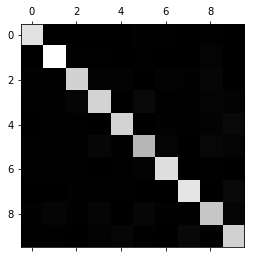

In [106]:
plt.matshow(conf_mx, cmap = plt.cm.gray)

plt.show()

這個混淆矩陣的結果看起来不錯，因为大多數圖像都在主對角線上，這表示是有正確被分類。數字 5 看起来比其他數字稍暗，可能是因為數據集中數字 5 的圖像較少，或者分類器在數字 5 上的表現不如其他數字。 

把重點放在錯誤上，首先，需要將混淆矩陣中的每個值除以相對應的類別中的圖像數量，這樣比較的就是錯誤率（相對錯誤率）而不是絕對錯誤數（絕對錯誤數對圖片數量較多的類別不公平的）

In [107]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums

用 0 填充對角線，只保留錯誤，重新繪製結果

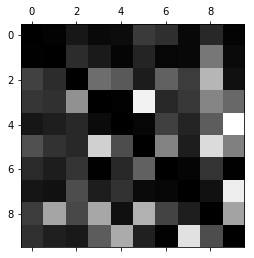

In [108]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

plt.show()

可以清楚地看到分類器產生的錯誤類型。其中，列表示實際的類，而行表示預測的類。

第 8 行和 第 9 行非常明亮，說明許多圖像被錯誤分類為數字 8 或數字 9。
同樣地，類別 8 和類別 9 的列也非常明亮，說明數字 8 和數字 9 經常會跟其他數字混淆。
有些列則非常暗，例如第 1 列：這意味大多數 1 都被正確分類（有一些與數字 8 混淆）。
錯誤並不完全對稱，例如，有更多的數字 5 被錯誤分類為數字 8 而不是更多的數字 8 被分類為數字 5。

根據這張圖，似乎應該花在改進數字 8 和數字 9上，以及修正數字 3 和數字 5 的混淆。
例如，可以試著收集更多這些數字的訓練數據。或者可以開發一些新特徵來改進分類器，再或者可以對圖片進行預處理（例如，使用Scikit-Image，Pillow或OpenCV）使某些圖案更突出。

分析單個錯誤也可以為分類器來獲得分類器在做什麼以及它失敗的原因，但它更困难和耗時。

來看數字 3 和數字 5 的例子。

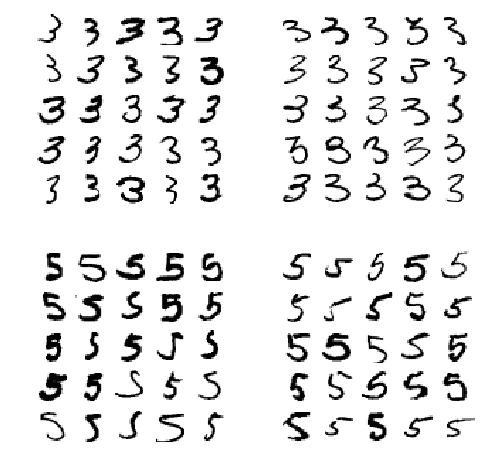

In [109]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize = (8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)

plt.show()

左側的兩個 5×5 矩陣顯示分類為數字 3 的圖片，右侧兩個 5×5 矩陣顯示了被分為數字 5 的圖片。分類器弄錯的數字（即，在左下方和右上方的矩陣）有一些寫得非常糟糕，甚至是人類也很難區別（例如，第 8 列和第 1 行的 5 真正看起來像 3）。

然而，大多數錯誤分類的圖像似乎是明顯的錯誤，原因是使用了一個簡單的 SGDClassifier，它是一個線性模型。所做的只是為每個像素分配一個各個類别的權重，當看到一個新圖像時，將加權後的像素強度匯總，從得到一個分數進行分類。而數字 3 和數字5 僅在一部分像素上有區別，所以分類器很容易弄混。

換句話說，這個分類器是對圖像位移和旋轉非常敏感。所以减少數字 3 和數字 5 混淆的一種方法就是對圖片進行預處理，確保它們位於中心位置且沒有旋轉，這同樣有助於減少其他錯誤。

# Multilabel Classification

在某些情況下，希望分類器為每個實例輸出多個類別。這種輸出多個二元標籤的分類系統稱為多標籤分類（Multilabel Classification）系統。

In [110]:
from sklearn.neighbors import KNeighborsClassifier

In [111]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [112]:
knn_clf = KNeighborsClassifier()

In [113]:
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

先建立一個 y_multilabel 數組，這個數組包含兩個目標標籤：第一個表示數字是否是大樹（7, 8 或 9），第二個表示是否是奇數。 接著建立一個KNeighborsClassifier（它是支持多標籤分類，而不是所有分類器都支持），最後使用多個目標數組進行訓練。 

可以進行預測，並注意它輸出的兩個標籤

In [114]:
knn_clf.predict([some_digit])

array([[False,  True]])

結果正確，數字 5 的確不大（False），同時也是奇數（True）。

評估多標籤分類器的方法有很多種，如何選擇正確的度量指標取決於應用的項目。 比如一種方法是測量每個標籤的 F1 分數（或是之前討論過的任何其他二元分類器指標），然後簡單地平均。

In [115]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = -1)
f1_score(y_multilabel, y_train_knn_pred, average= 'macro')

0.9776912618813947

這裏假設所有標籤都同樣重要，但實際情況可能並非如此。一個簡單的辦法是給每個標籤設置一個等於其自身*支持* 的權重（也就是具有該目標標籤的實例的數量）。 要做到這一點，只需在前面的代碼中設置 **average = 'weighted'**。

# Multioutput Classification

多輸出-多類別分類（或簡稱多輸出分類）。它是多標籤分類的一般化，其標籤也可以是多種類別的（比如可以有兩個以上可能的值）。

可以看一個從圖片中去除噪聲的系统。 輸入一個有噪聲的圖片，它將輸出一個乾淨的數字圖片，就像 MNIST 圖片一樣，以像素強度的一個數組作為呈現方式。

注意，這個分類器的輸出是多個標籤（一個像素點一个標籤），每個標籤可以有多個值（像素強度範圍從 0 到 255）。 所以這是一個多輸出分類器系統的例子。

先使用 NumPy 的 randint() 將噪聲添加到像素強度。

In [119]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

In [120]:
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

目標圖片將是原始圖像

In [121]:
y_train_mod = X_train
y_test_mod = X_test

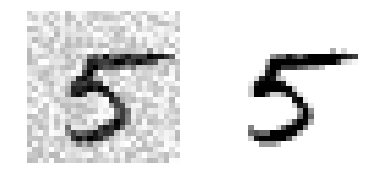

In [123]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

plt.show()

看測試集中的圖像，左邊是噪聲的輸入圖像，右邊是乾淨的目標圖像。

透過訓練分類器，清洗這張圖片

In [124]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [125]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])

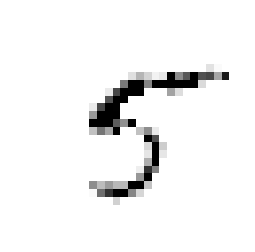

In [126]:
plot_digit(clean_digit)

# Extra material

## Dummy (ie. random) classifier

In [127]:
from sklearn.dummy import DummyClassifier

In [128]:
dmy_clf = DummyClassifier()

In [129]:
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv = 3, method = 'predict_proba')
y_scores_dmy = y_probas_dmy[:, 1]

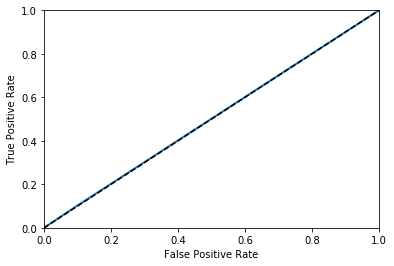

In [130]:
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)

## KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn_clf = KNeighborsClassifier(n_jobs = -1, weights = 'distance', n_neighbors = 4)

In [ ]:
knn_clf.fit(X_train, y_train)

In [ ]:
y_knn_pred = knn_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, y_knn_pred)

In [ ]:
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_digit(digit_array, dx, dy, new = 0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval = new).reshape(784)

In [ ]:
plot_digit(shift_digit(some_digit, 5, 1, new = 100))

In [ ]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis = 1, arr = X_train, dx = dx, dy = dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

In [ ]:
X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

In [ ]:
knn_clf.fit(X_train_expanded, y_train_expanded)

In [ ]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [ ]:
accuracy_score(y_test, y_knn_expanded_pred)

In [ ]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

In [ ]:
plot_digit(ambiguous_digit)

# 心得

這一章主題是分類，從二元分類器開始到多元分類器，介紹了幾個分類器內容，並且針對分類器的性能評估，提供幾個指標，像是精度和召回率、 ROC 曲線、混淆矩陣等，都可以用來衡量分類器的效能。之後再用個例子說明了錯誤分析的過程與方向，作為分類器不佳時可以調整的參考。最後再討論了多標籤分類與多輸出分類，結束分類這個主題。

整題來說，應該會知道如何為分類任務選擇好的指標，選擇適當的精度/召回權衡，選擇適當的比較分類器，以及更一般地為各種任務建立良好的分類系统。